# 1. Introdução

## 1.1. Objetivos
Nesta segunda parte o objetivo é estimar o número de nós (carros) dado as métricas do sistema. A análise vai seguir quase que rigorosamente o que foi feito na primeira parte, com algumas poucas modificações pontuais.

A variável *target* agora será ***n_nodes***. E dando prosseguimento ao *notebook* veremos será necessário  aplicar o método de regressão nesse problema.

# 2. Implementação

Importando todas as bibliotecas necessárias



In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

O dataset utilizado é composto pelos resultados de diversas simulações. Cada simulação foi conduzida para um certo número de nós na rede.

***Foram realizadas 19 simulações, variando o número de nós de 10 em 10, iniciando em 10, incrementando até 200. Cada simulação possui 1000 samples. ***

O dataset final possui 19000 samples, de forma que, após a união dos datasets, foi feito um shuffle.

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving vanet-routing.output_node_all.csv to vanet-routing.output_node_all.csv
User uploaded file "vanet-routing.output_node_all.csv" with length 3785748 bytes


In [7]:

vanet = pd.read_csv("vanet-routing.output_node_all.csv")
vanet.head()

,SimulationSecond,ReceiveRate,PacketsReceived,NumberOfSinks,RoutingProtocol,TransmissionPower,WavePktsSent,WavePtksReceived,WavePktsPpr,ExpectedWavePktsReceived,...,BSM_PDR4,BSM_PDR5,BSM_PDR6,BSM_PDR7,BSM_PDR8,BSM_PDR9,BSM_PDR10,MacPhyOverhead,m_nodeSpeed,n_nodes
0,459,16.384,32,10,protocol,7.5,700,11339,16.1986,1254,...,0.541032,0.513870,0.479977,0.447392,0.447392,0.447392,0.447392,0.510912,20,70.0
1,582,19.968,39,10,protocol,7.5,1300,28356,21.8123,4011,...,0.418215,0.392977,0.362701,0.330508,0.330508,0.330508,0.330508,0.504567,20,130.0
2,708,12.288,24,10,protocol,7.5,1400,26982,19.2729,3966,...,0.385750,0.351837,0.316640,0.283833,0.283833,0.283833,0.283833,0.501674,20,140.0
3,396,17.408,34,10,protocol,7.5,1400,25347,18.1050,3598,...,0.390144,0.353879,0.316605,0.283707,0.283707,0.283707,0.283707,0.494955,20,140.0
4,699,16.384,32,10,protocol,7.5,2000,54047,27.0235,9575,...,0.334789,0.312529,0.285955,0.258517,0.258517,0.258517,0.258517,0.473248,20,200.0


Separando os conjuntos de treino e teste (holdout)

In [8]:
train = vanet.iloc[0:np.rint(0.6*len(vanet)).astype(int)]
print(len(vanet))
print(train.head())

holdout = vanet.iloc[np.rint(0.6*len(vanet)).astype(int):]

19019
   SimulationSecond  ReceiveRate  PacketsReceived  NumberOfSinks  \
0               459       16.384               32             10   
1               582       19.968               39             10   
2               708       12.288               24             10   
3               396       17.408               34             10   
4               699       16.384               32             10   

  RoutingProtocol  TransmissionPower  WavePktsSent  WavePtksReceived  \
0        protocol                7.5           700             11339   
1        protocol                7.5          1300             28356   
2        protocol                7.5          1400             26982   
3        protocol                7.5          1400             25347   
4        protocol                7.5          2000             54047   

   WavePktsPpr  ExpectedWavePktsReceived   ...     BSM_PDR4  BSM_PDR5  \
0      16.1986                      1254   ...     0.541032  0.513870   
1     

Aplicando normalização com a função MinMaxScaler

In [9]:
from sklearn.preprocessing import MinMaxScaler

features=['SimulationSecond','ReceiveRate','PacketsReceived','WavePktsSent','WavePtksReceived','WavePktsPpr','ExpectedWavePktsReceived',
        'ExpectedWavePktsInCoverageReceived','BSM_PDR1','BSM_PDR2','BSM_PDR3','BSM_PDR4','BSM_PDR5','BSM_PDR6','BSM_PDR7','BSM_PDR8','BSM_PDR9','BSM_PDR10',
        'MacPhyOverhead','m_nodeSpeed']

for feature in features:
  scaler = MinMaxScaler()
  train[[feature]]=scaler.fit_transform(train[[feature]])
  holdout[[feature]]=scaler.transform(holdout[[feature]])

print(train.head())
print("======================================================")
print(holdout.head())

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: Setting

   SimulationSecond  ReceiveRate  PacketsReceived  NumberOfSinks  \
0             0.459     0.561404         0.561404             10   
1             0.582     0.684211         0.684211             10   
2             0.708     0.421053         0.421053             10   
3             0.396     0.596491         0.596491             10   
4             0.699     0.561404         0.561404             10   

  RoutingProtocol  TransmissionPower  WavePktsSent  WavePtksReceived  \
0        protocol                7.5          0.35          0.185977   
1        protocol                7.5          0.65          0.465081   
2        protocol                7.5          0.70          0.442546   
3        protocol                7.5          0.70          0.415729   
4        protocol                7.5          1.00          0.886452   

   WavePktsPpr  ExpectedWavePktsReceived   ...     BSM_PDR4  BSM_PDR5  \
0     0.528254                  0.109548   ...     0.541032  0.513870   
1     0.7113

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Com relação a primeira parte temos agora uma nova *feature*, ***n_nodes***, que representa o número de nós da rede. Vamos ver a correlação entre essa nova coluna e as demais e também vamos plotar alguns gráficos para análise exploratória.

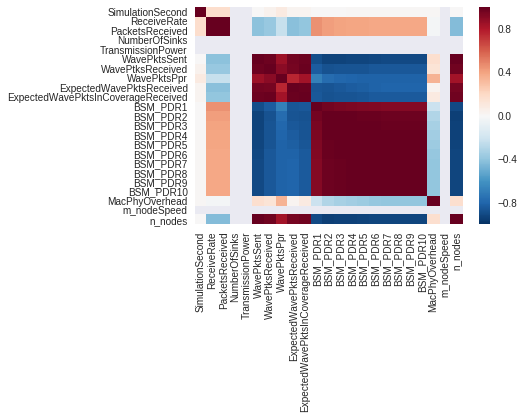

In [10]:
sns.heatmap(vanet.corr())

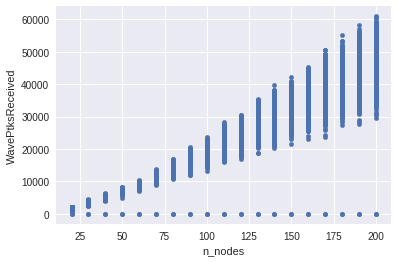

In [11]:
vanet.plot(x='n_nodes', y='WavePtksReceived', kind='scatter')
plt.show()

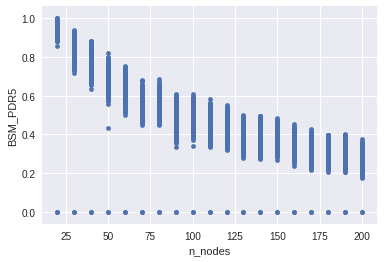

In [12]:
vanet.plot(x='n_nodes', y='BSM_PDR5', kind='scatter')
plt.show()

nota-se que as colunas com maior correlação com o número de nós são: ***WavePtksSent***, ***WavePtsReceived***, ***WavePtksPpr***, ***ExpectedWavePtksReceveid*** e ***ExpectedWavePtksInCoverageReceveid***. Essas *features* são justamente, por intuição, as que melhor representam as estatísticas da rede dado um número variante de nós.  Além disto, ver-se que todas apresentam um comportamento linear com relação a variável *target*  ****n_nodes***.

-------
Utiliza-se agora a função "*select_features*" para escolher quais *features* devem ser utilizadas para um determinado algoritmo. Tal prática permite prevenir o *overfitting*, eliminando *features* redundantes.
Além disto, já se define com quais regressores vamos trabalhar para o processo de aprendizagem. Visto que esse é um problema de estimação, então utiliza-se o método de regressão para sua resolução. Os regressores escolhidos para se comparar os resultados foram: ***LinearRegression***, ***Lasso***, ***Ridge*** e ***SDGRegressor*** e ***MLPRegressor***.

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Perceptron

def select_features(df,index):
    
 
    all_X = df.drop(['SimulationSecond','RoutingProtocol','TransmissionPower', 'NumberOfSinks','n_nodes'],axis=1) #colunas com zero de correlacao
    all_y = df["n_nodes"]
    
    clf_lr = LinearRegression()
    clf_la = Lasso(alpha=0.1)
    clf_ri = Ridge(alpha=0.1)
    clf_sgd = SGDRegressor(max_iter=1000, penalty=None, eta0=0.1, random_state=42)
    
    clfs = [clf_lr,clf_la,clf_ri, clf_sgd]
    

    
    selector = RFECV(clfs[index],cv=10,n_jobs=-1)
    selector.fit(all_X,all_y)
    best_columns = list(all_X.columns[selector.support_])
    
    return best_columns

cols_lr = select_features(train,0)
cols_la = select_features(train,1)
cols_ri = select_features(train,2)
cols_sgd = select_features(train,3)

print(cols_lr)
print(cols_la)
print(cols_ri)
print(cols_sgd)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If

['ReceiveRate', 'PacketsReceived', 'WavePktsSent', 'WavePtksReceived', 'WavePktsPpr', 'ExpectedWavePktsReceived', 'ExpectedWavePktsInCoverageReceived', 'BSM_PDR1', 'BSM_PDR2', 'BSM_PDR3', 'BSM_PDR4', 'BSM_PDR6', 'BSM_PDR7', 'BSM_PDR9']
['ReceiveRate', 'PacketsReceived', 'WavePktsSent', 'WavePtksReceived', 'ExpectedWavePktsReceived', 'ExpectedWavePktsInCoverageReceived', 'BSM_PDR1', 'BSM_PDR2', 'BSM_PDR10']
['WavePktsSent', 'WavePtksReceived', 'WavePktsPpr', 'ExpectedWavePktsReceived', 'ExpectedWavePktsInCoverageReceived', 'BSM_PDR2', 'BSM_PDR3', 'BSM_PDR4', 'BSM_PDR6', 'BSM_PDR7']
['WavePktsSent', 'WavePtksReceived', 'WavePktsPpr', 'ExpectedWavePktsReceived', 'ExpectedWavePktsInCoverageReceived', 'BSM_PDR2', 'BSM_PDR3', 'BSM_PDR4', 'BSM_PDR6', 'BSM_PDR8', 'BSM_PDR9', 'BSM_PDR10']


Agora, define-se os regressores e se faz o treinamento com os dados em *train*

In [0]:
clf_lr = LinearRegression()
clf_la = Lasso(alpha=0.1)
clf_ri = Ridge(alpha=0.1)
clf_sgd = SGDRegressor(max_iter=1000, penalty=None, eta0=0.1, random_state=42)
clf_NNR = MLPRegressor(max_iter=1000)

In [15]:
clf_lr.fit(train[cols_lr],train["n_nodes"])
clf_la.fit(train[cols_la],train["n_nodes"])
clf_ri.fit(train[cols_ri],train["n_nodes"])
clf_sgd.fit(train[cols_sgd],train["n_nodes"])
clf_NNR.fit(train[cols_lr],train["n_nodes"])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Com os regressores treinados, passa-se agora a predição da quantidade de nós usando os dados no *holdout*

In [0]:
pred_lr = clf_lr.predict(holdout[cols_lr])
pred_la = clf_la.predict(holdout[cols_la])
pred_ri = clf_ri.predict(holdout[cols_ri])
pred_sgd = clf_sgd.predict(holdout[cols_sgd])
pred_NNR = clf_NNR.predict(holdout[cols_lr])

cálculo do *root mean squared error* e print

In [0]:
rmse_lr = np.sqrt(mean_squared_error(pred_lr, holdout["n_nodes"]))
rmse_la = np.sqrt(mean_squared_error(pred_la, holdout["n_nodes"]))
rmse_ri = np.sqrt(mean_squared_error(pred_ri, holdout["n_nodes"]))
rmse_sgd = np.sqrt(mean_squared_error(pred_sgd, holdout["n_nodes"]))
rmse_NNR = np.sqrt(mean_squared_error(pred_NNR, holdout["n_nodes"]))

In [18]:
print(rmse_lr)
print(rmse_la)
print(rmse_ri)
print(rmse_sgd)
print(rmse_NNR)

3.022158072057887
3.3602509326107985
3.0438693250413524
3.063588358124299
2.067034386246902


nota-se que todos os estimadores se sairam muito bem, com um ***RMSE*** muito baixo, principalmente o ***MLPRegressor***, que apresentou um valor mais baixo ainda com relação aos demais. Os motivos para tal desempenho pode ser ecplicado pela capacidade de um rede neural em formular, encontrar, relações implicitas nos dados que os demais estimadores não conseguem.

Abaixo está um *preview* do primeiros valores de número de nós no teste e no que foi predito.

In [19]:
print(pred_NNR[0:10])
print("--------------")
print(holdout["n_nodes"].head(10).values)

[ 28.71703737  20.48939083 200.03685329 149.68746459 150.36112403
 169.91708104 179.57313474  90.34420673  99.82622383  39.85631771]
--------------
[ 30.  20. 200. 150. 150. 170. 180.  90. 100.  40.]


Bom, mais fica a o questionamento se o melhor estimador está com *overfitting* ou não. Para saber, vamos estimar o número de nós com os dados de treinamento usando o melhor estimador.

In [20]:
pred_NNR_train = clf_NNR.predict(train[cols_lr])
rmse_NNR_train = np.sqrt(mean_squared_error(pred_NNR_train, train["n_nodes"]))
print(rmse_NNR_train)

2.7567302576463666


Vamos que o ***RMSE*** com os dados de treinamento deu maior que o do para dados de teste, porém dado a diferença, não consideramos **overfitting***, quanto menos ***underfitting***. 

Para finalizar vamos fazer o mesmo processo mais agora levando em conta só as médias dos 5 primeiros ***BSM_PDR*** e dos 5 últimos. 

In [27]:
bsmpdr15 = ['BSM_PDR1', 'BSM_PDR2','BSM_PDR3', 'BSM_PDR4','BSM_PDR5']
bsmpdr610 = ['BSM_PDR6', 'BSM_PDR7','BSM_PDR8', 'BSM_PDR9','BSM_PDR10']

vanet_copy = vanet.copy()

vanet_copy['BSM_PDR1-5_MEAN'] = vanet_copy[bsmpdr15].mean(axis=1)
vanet_copy['BSM_PDR6-10_MEAN'] = vanet_copy[bsmpdr610].mean(axis=1)
vanet_copy = vanet_copy.drop(['BSM_PDR1', 'BSM_PDR2','BSM_PDR3', 'BSM_PDR4','BSM_PDR5','BSM_PDR6', 'BSM_PDR7','BSM_PDR8', 'BSM_PDR9','BSM_PDR10'],axis=1)

train2 = vanet_copy.iloc[0:np.rint(0.6*len(vanet_copy)).astype(int)]
holdout2=vanet_copy.iloc[np.rint(0.6*len(vanet_copy)).astype(int):]

features=['SimulationSecond','ReceiveRate','PacketsReceived','WavePktsSent','WavePtksReceived','WavePktsPpr','ExpectedWavePktsReceived',
        'ExpectedWavePktsInCoverageReceived','MacPhyOverhead','m_nodeSpeed', 'BSM_PDR1-5_MEAN', 'BSM_PDR6-10_MEAN']

for feature in features:
  scaler2 = MinMaxScaler()
  train2[[feature]]=scaler2.fit_transform(train2[[feature]])
  holdout2[[feature]]=scaler2.transform(holdout2[[feature]])

cols_lr = select_features(train2,0)
cols_la = select_features(train2,1)
cols_ri = select_features(train2,2)
cols_sgd = select_features(train2,3)


print(cols_lr)
print(cols_la)
print(cols_ri)
print(cols_sgd)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is

['ReceiveRate', 'PacketsReceived', 'WavePktsSent', 'WavePtksReceived', 'WavePktsPpr', 'ExpectedWavePktsReceived', 'ExpectedWavePktsInCoverageReceived', 'm_nodeSpeed', 'BSM_PDR1-5_MEAN', 'BSM_PDR6-10_MEAN']
['ReceiveRate', 'WavePktsSent', 'WavePtksReceived', 'ExpectedWavePktsReceived', 'ExpectedWavePktsInCoverageReceived', 'BSM_PDR1-5_MEAN']
['WavePktsSent', 'WavePtksReceived', 'WavePktsPpr', 'ExpectedWavePktsReceived', 'ExpectedWavePktsInCoverageReceived', 'BSM_PDR1-5_MEAN', 'BSM_PDR6-10_MEAN']
['WavePktsSent', 'WavePtksReceived', 'WavePktsPpr', 'ExpectedWavePktsReceived', 'ExpectedWavePktsInCoverageReceived', 'BSM_PDR1-5_MEAN', 'BSM_PDR6-10_MEAN']


Mariz de correlação e plots para as novas *features*:

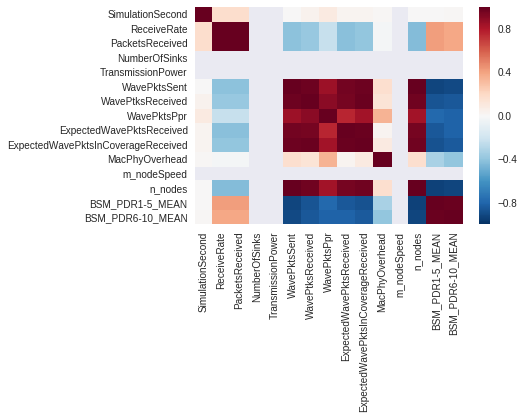

In [28]:
sns.heatmap(vanet_copy.corr())

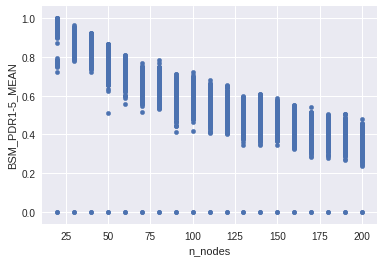

In [29]:
vanet_copy.plot(x='n_nodes', y='BSM_PDR1-5_MEAN', kind='scatter')

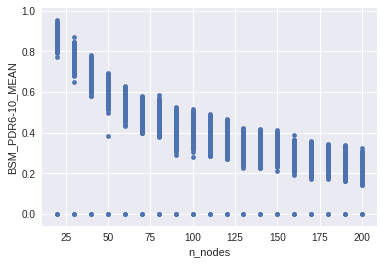

In [30]:
vanet_copy.plot(x='n_nodes', y='BSM_PDR6-10_MEAN', kind='scatter')

*Fitting* e estimação para os novos dados:

In [31]:
clf_lr.fit(train2[cols_lr],train2["n_nodes"])
clf_la.fit(train2[cols_la],train2["n_nodes"])
clf_ri.fit(train2[cols_ri],train2["n_nodes"])
clf_sgd.fit(train2[cols_sgd],train2["n_nodes"])
clf_NNR.fit(train2[cols_lr],train2["n_nodes"])

pred_lr2 = clf_lr.predict(holdout2[cols_lr])
pred_la2 = clf_la.predict(holdout2[cols_la])
pred_ri2 = clf_ri.predict(holdout2[cols_ri])
pred_sgd2 = clf_sgd.predict(holdout2[cols_sgd])
pred_NNR2 = clf_NNR.predict(holdout2[cols_lr])

rmse_lr2 = np.sqrt(mean_squared_error(pred_lr2, holdout2["n_nodes"]))
rmse_la2 = np.sqrt(mean_squared_error(pred_la2, holdout2["n_nodes"]))
rmse_ri2 = np.sqrt(mean_squared_error(pred_ri2, holdout2["n_nodes"]))
rmse_sgd2 = np.sqrt(mean_squared_error(pred_sgd2, holdout2["n_nodes"]))
rmse_NNR2 = np.sqrt(mean_squared_error(pred_NNR2, holdout2["n_nodes"]))

print(rmse_lr2)
print(rmse_la2)
print(rmse_ri2)
print(rmse_sgd2)
print(rmse_NNR2)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


3.0608675091572977
3.42223177661065
3.0716107108074078
3.0769374050331106
2.19685753912369
